# Second iteration ( Window method )

LSTM for Regression Using the Window Method
We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

## Load the Data

In [ ]:
#Import the necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from pandas.plotting import scatter_matrix
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import train_test_split

# create scorer
scorer = make_scorer(mean_absolute_error)

# Load Iquitos preprocessed Data 
features_train_iq = pd.read_csv("preprocessed data/dengue_features_train_iq.csv")
labels_train_iq = pd.read_csv("preprocessed data/dengue_labels_train_iq.csv")
features_test_iq = pd.read_csv("preprocessed data/dengue_features_test_iq.csv")

# drop all columns referencing times
stripped_features_train_iq = features_train_iq.drop(['year','weekofyear','week_start_date'], axis=1)
stripped_labels_train_iq = labels_train_iq.drop(['year','weekofyear'], axis=1)
stripped_features_test_iq = features_test_iq.drop(['year','weekofyear','week_start_date'], axis=1)

# Load San Juan preprocessed Data 
features_train_sj = pd.read_csv("preprocessed data/dengue_features_train_sj.csv")
labels_train_sj = pd.read_csv("preprocessed data/dengue_labels_train_sj.csv")
features_test_sj = pd.read_csv("preprocessed data/dengue_features_test_sj.csv")

stripped_features_train_sj = features_train_sj.drop(['year','weekofyear','week_start_date'], axis=1)
stripped_labels_train_sj = labels_train_sj.drop(['year','weekofyear'], axis=1)
stripped_features_test_sj = features_test_sj.drop(['year','weekofyear','week_start_date'], axis=1)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
        indexes of removed rows

    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


def prepare_data_with_window (data_train, data_labels, data_test, window_size):
    
    data = data_train.append(data_test)
    
    data_w = series_to_supervised(data, n_in=window_size, dropnan=True)
    
    #split
    data_train_w = data_w.iloc[ : (len(data_train) - window_size)]
    data_test_w = data_w.iloc[(len(data_train) - window_size) : ]
    data_labels_w = data_labels.iloc[window_size : ]
    
    return data_train_w, data_labels_w, data_test_w
 
window_size = 12
    
# prepare Iquitos dataset with a window of size 2
w_stripped_features_train_iq, w_stripped_labels_train_iq, w_stripped_features_test_iq = prepare_data_with_window(
    stripped_features_train_iq, 
    stripped_labels_train_iq, 
    stripped_features_test_iq, window_size)

w_features_train_iq = features_train_iq.iloc[window_size : ]
w_labels_train_iq = labels_train_iq.iloc[window_size : ]


# prepare San Juan dataset with a window of size 2
w_stripped_features_train_sj, w_stripped_labels_train_sj, w_stripped_features_test_sj = prepare_data_with_window(
    stripped_features_train_sj, 
    stripped_labels_train_sj, 
    stripped_features_test_sj, window_size)

w_features_train_sj = features_train_sj.iloc[window_size : ]
w_labels_train_sj = labels_train_sj.iloc[window_size : ]


## Random Forest

### Initialization

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

scorer = make_scorer(mean_absolute_error)

clf = RandomForestRegressor(random_state=42)

parameters = {'n_estimators': [50, 100, 150, 200, 250]}

### Iquitos

In [ ]:
cv_sets_iq = ShuffleSplit(w_stripped_features_train_iq.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
grid_obj_iq = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=cv_sets_iq)

grid_fit_iq = grid_obj_iq.fit(w_stripped_features_train_iq, w_stripped_labels_train_iq["total_cases"])

# Get the estimator
best_clf_iq = grid_fit_iq.best_estimator_

# Make predictions using the unoptimized and model
best_predictions_iq = best_clf_iq.predict(w_stripped_features_test_iq)
best_predictions_iq  = np.around(best_predictions_iq, decimals=0)
best_predictions_iq = best_predictions_iq.astype(int)

### San Juan

In [ ]:
cv_sets_sj = ShuffleSplit(w_stripped_features_train_sj.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
grid_obj_sj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=cv_sets_sj)

grid_fit_sj = grid_obj_sj.fit(w_stripped_features_train_sj, w_stripped_labels_train_sj["total_cases"])

# Get the estimator
best_clf_sj = grid_fit_sj.best_estimator_

# Make predictions using the unoptimized and model
best_predictions_sj = best_clf_sj.predict(w_stripped_features_test_sj)
best_predictions_sj  = np.around(best_predictions_sj, decimals=0)
best_predictions_sj = best_predictions_sj.astype(int)

### Create Random Forest Submission File

In [ ]:
# San Juan - city,year,weekofyear,total_cases
submission_sj = features_test_sj[['year','weekofyear']]
submission_sj.insert( 0,'city','sj')

df_best_predictions_sj = pd.DataFrame(best_predictions_sj, columns=['total_cases'])
submission_sj = pd.concat([submission_sj, df_best_predictions_sj], axis=1)

# Iquitos - city,year,weekofyear,total_cases
submission_iq = features_test_iq[['year','weekofyear']]
submission_iq.insert( 0,'city','iq')

df_best_predictions_iq = pd.DataFrame(best_predictions_iq, columns=['total_cases'])
submission_iq = pd.concat([submission_iq, df_best_predictions_iq], axis=1)

# join both predictions
submission = pd.concat([submission_sj, submission_iq])
submission = submission.reset_index(drop = True)

#write into csv
submission.to_csv("Submission\Submission_it2_w4_RandomForest.csv", encoding='utf-8', index=False)

### Submission Score 

#### Window size 2:

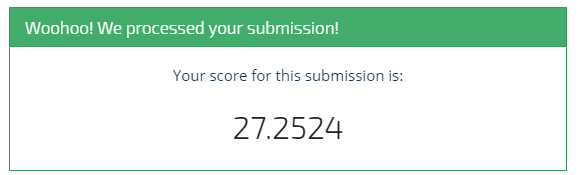

#### Window size 4:

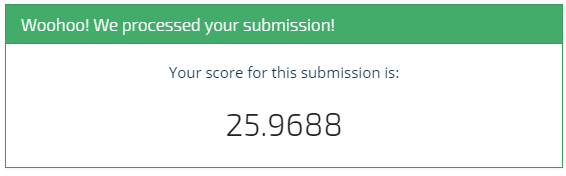

#### window size 44


## AdaBoost


### Initialization

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

clf = AdaBoostRegressor(random_state=42)

# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [50, 100, 150, 200, 250], 'learning_rate' : [0.6, 0.75, 1, 1.25, 1.4]}

### Iquitos

In [ ]:
cv_sets_iq = ShuffleSplit(w_stripped_features_train_iq.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
grid_obj_iq = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=cv_sets_iq)

grid_fit_iq = grid_obj_iq.fit(w_stripped_features_train_iq, w_stripped_labels_train_iq["total_cases"])

# Get the estimator
best_clf_iq = grid_fit_iq.best_estimator_

# Make predictions using the unoptimized and model
best_predictions_iq = best_clf_iq.predict(w_stripped_features_test_iq)
best_predictions_iq  = np.around(best_predictions_iq, decimals=0)
best_predictions_iq = best_predictions_iq.astype(int)

### San Juan

In [ ]:
cv_sets_sj = ShuffleSplit(w_stripped_features_train_sj.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
grid_obj_sj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=cv_sets_sj)

grid_fit_sj = grid_obj_sj.fit(w_stripped_features_train_sj, w_stripped_labels_train_sj["total_cases"])

# Get the estimator
best_clf_sj = grid_fit_sj.best_estimator_

# Make predictions using the unoptimized and model
best_predictions_sj = best_clf_sj.predict(w_stripped_features_test_sj)
best_predictions_sj  = np.around(best_predictions_sj, decimals=0)
best_predictions_sj = best_predictions_sj.astype(int)

### Create AdaBoost Submission File

In [ ]:
# San Juan - city,year,weekofyear,total_cases
submission_sj = features_test_sj[['year','weekofyear']]
submission_sj.insert( 0,'city','sj')

df_best_predictions_sj = pd.DataFrame(best_predictions_sj, columns=['total_cases'])
submission_sj = pd.concat([submission_sj, df_best_predictions_sj], axis=1)

# Iquitos - city,year,weekofyear,total_cases
submission_iq = features_test_iq[['year','weekofyear']]
submission_iq.insert( 0,'city','iq')

df_best_predictions_iq = pd.DataFrame(best_predictions_iq, columns=['total_cases'])
submission_iq = pd.concat([submission_iq, df_best_predictions_iq], axis=1)

# join both predictions
submission = pd.concat([submission_sj, submission_iq])
submission = submission.reset_index(drop = True)

#write into csv
submission.to_csv("Submission\Submission_it2_w2_AdaBoost.csv", encoding='utf-8', index=False)

### Submission Score 

#### Window size 2:
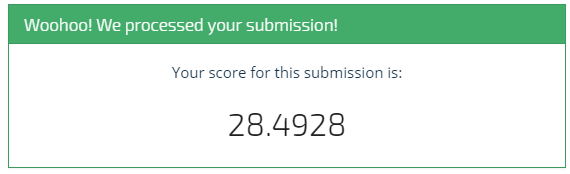

#### Window size 4:
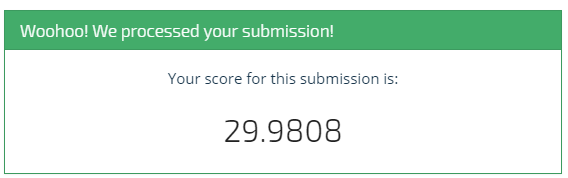

#### window size 44


## Long Short-Term Memory (LSTM)

### Initialization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1L2

reg = L1L2(l1=0.0, l2=0.00001)
#reg = L1L2(l1=0.0, l2=0.00)

columns_to_scale = w_stripped_features_test_iq.columns.difference(['data_set'])

# Initialize a scaler and apply it to the features
scaler = MinMaxScaler(feature_range=(0, 1)) # default=(0, 1)

### Iquitos

In [ ]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_iq['data_set'] = 'train'
w_stripped_features_test_iq['data_set']  = 'test'

dengue_norm_features_iq  = w_stripped_features_train_iq.append(w_stripped_features_test_iq)
dengue_norm_features_iq[columns_to_scale] = scaler.fit_transform(dengue_norm_features_iq[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'train']
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.reset_index(drop = True)
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'test']
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.reset_index(drop = True)
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_iq = scaler.fit(w_stripped_labels_train_iq)
stripped_norm_dengue_labels_train_iq = scalerLabels_iq.transform(w_stripped_labels_train_iq)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_iq, [int(.8*len(stripped_norm_dengue_features_train_iq))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_iq, [int(.8*len(stripped_norm_dengue_labels_train_iq))])

X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_iq.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_submission = X_submission.reshape((X_submission.shape[0], 1, X_submission.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_submission.shape)

#design network
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(240, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("relu"))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# train model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.it2.iq.hdf5', verbose=2, 
                               save_best_only=True)

# fit network       
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

In [ ]:
# load best weights
model.load_weights('saved_models/weights.best.it2.iq.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_iq = np.around(y_submission, decimals=0)
y_submission_iq = y_submission_iq.astype(int)

### San Juan

In [ ]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_sj['data_set'] = 'train'
w_stripped_features_test_sj['data_set']  = 'test'

dengue_norm_features_sj  = w_stripped_features_train_sj.append(w_stripped_features_test_sj)
dengue_norm_features_sj[columns_to_scale] = scaler.fit_transform(dengue_norm_features_sj[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'train']
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.reset_index(drop = True)
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'test']
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.reset_index(drop = True)
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_sj = scaler.fit(w_stripped_labels_train_sj)
stripped_norm_dengue_labels_train_sj = scalerLabels_sj.transform(w_stripped_labels_train_sj)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_sj, [int(.8*len(stripped_norm_dengue_features_train_sj))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_sj, [int(.8*len(stripped_norm_dengue_labels_train_sj))])

X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_sj.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_submission = X_submission.reshape((X_submission.shape[0], 1, X_submission.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_submission.shape)

#design network
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(240, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# fit network
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.it2.sj.hdf5', verbose=2, 
                               save_best_only=True)
        
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

In [ ]:
# load best weights
model.load_weights('saved_models/weights.best.it2.sj.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_sj = np.around(y_submission, decimals=0)
y_submission_sj = y_submission_sj.astype(int)

### Create LSTM Submission File

In [ ]:
# San Juan - city,year,weekofyear,total_cases
submission_sj = features_test_sj[['year','weekofyear']]
submission_sj.insert( 0,'city','sj')

df_y_submission_sj = pd.DataFrame(y_submission_sj, columns=['total_cases'])
submission_sj = pd.concat([submission_sj, df_y_submission_sj], axis=1)

# Iquitos - city,year,weekofyear,total_cases
submission_iq = features_test_iq[['year','weekofyear']]
submission_iq.insert( 0,'city','iq')

df_y_submission_iq = pd.DataFrame(y_submission_iq, columns=['total_cases'])
submission_iq = pd.concat([submission_iq, df_y_submission_iq], axis=1)

# join both predictions
submission = pd.concat([submission_sj, submission_iq])
submission = submission.reset_index(drop = True)

#write into csv
submission.to_csv("Submission/Submission_it2_lstm_b16_L2_w8.csv", encoding='utf-8', index=False)

### LSTM Submission Score 

#### With kernel regularizer L2 (0.00001),  Batch Size 16 and Window Size 2:
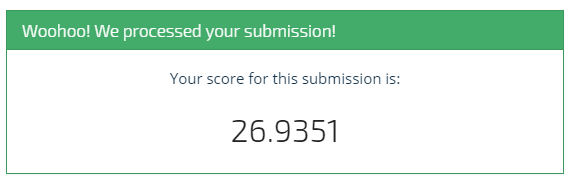

#### With kernel regularizer L2 (0.00001),  Batch Size 16 and Window Size 8:

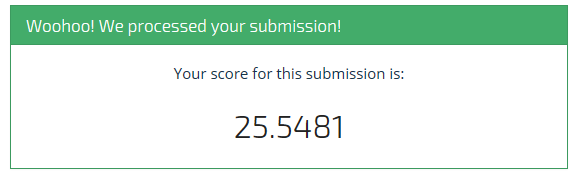

#### Without kernel regularizer,  Batch Size 16 and window size 4:

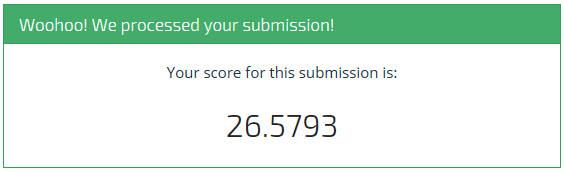

#### Without kernel regularizer,  Batch Size 32 and window size 8:

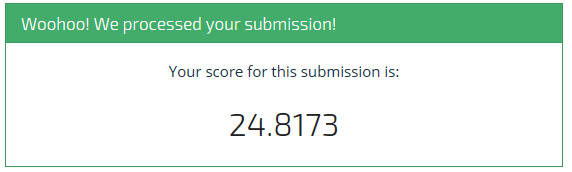

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 8:
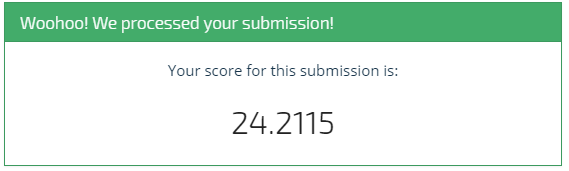

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 10:
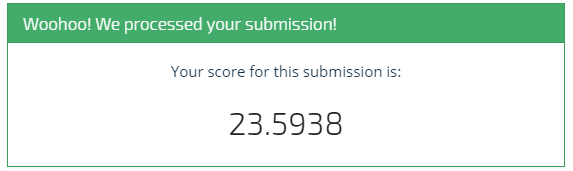

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 12:
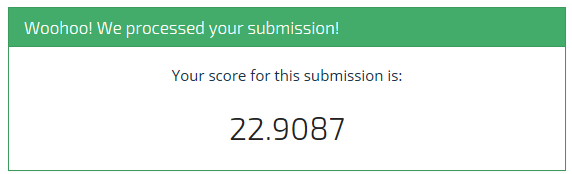

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 14:
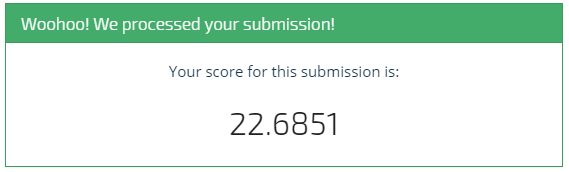

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 16:
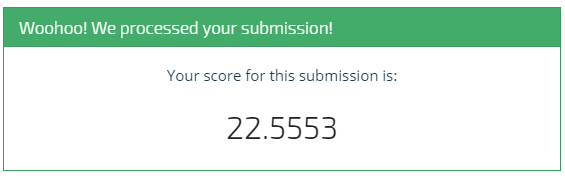

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 18:
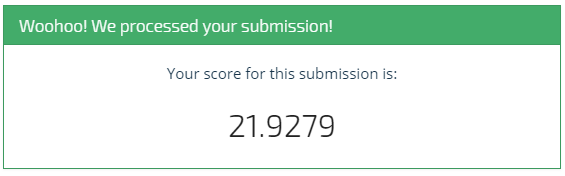

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 20:
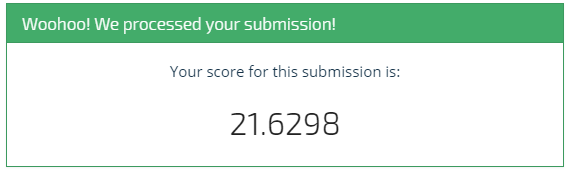

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 22:
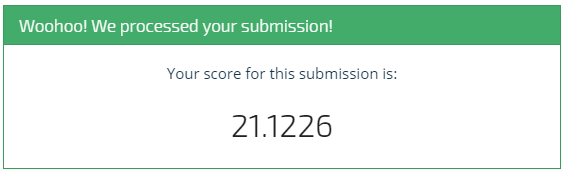

CURRENT RANK: 195
COMPETITORS: 4574

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 23:
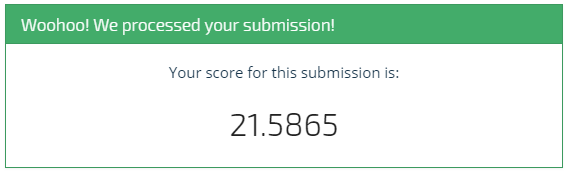

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 24:
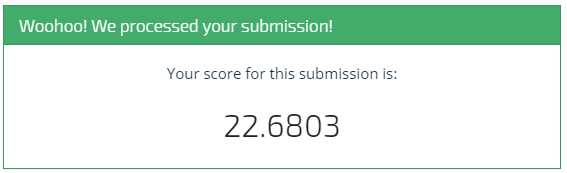

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 26:
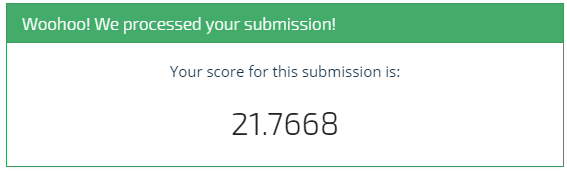

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 22:
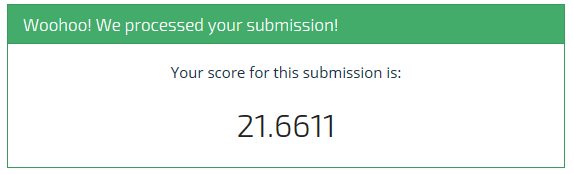

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 24:
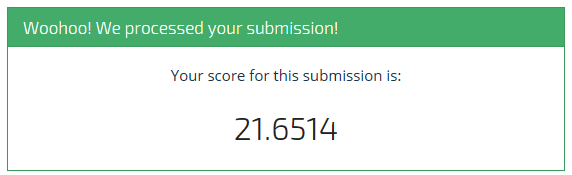

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 28:
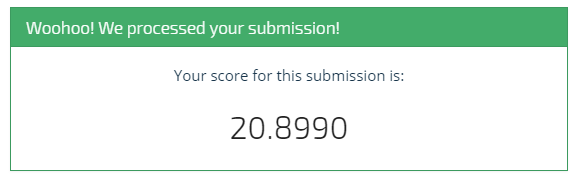

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 30:

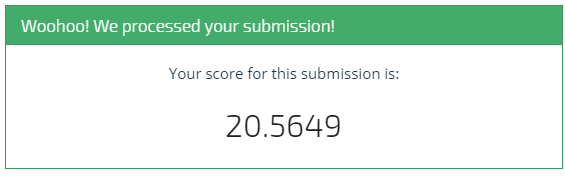

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 29:
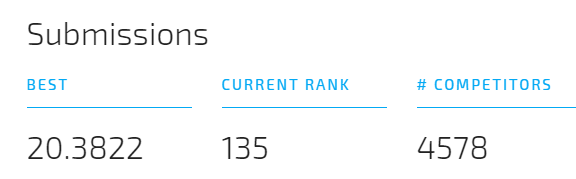

#### With kernel regularizer L2 (0.00001), Batch Size 40 and window size 44:

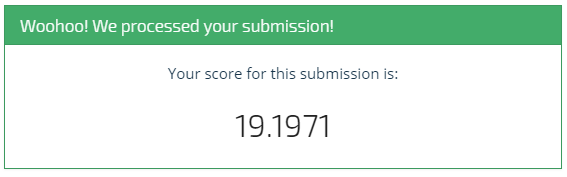

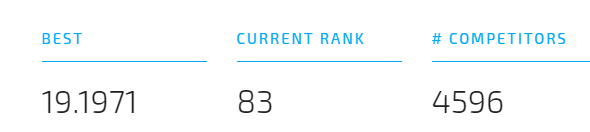

#### With kernel regularizer L2 (0.00001), Batch Size 51 and window size 2:
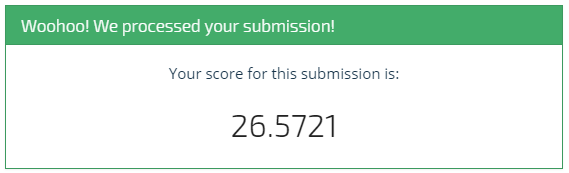

#### Without kernel regularizer,  Batch Size 51 and window size 4
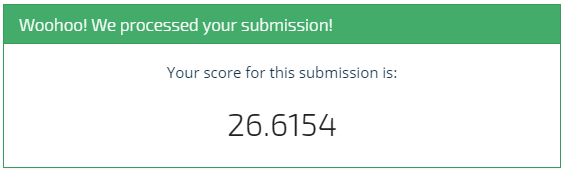

## Sequence classification with 1D convolutions

### Initialization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1L2

reg = L1L2(l1=0.0, l2=0.00001)
#reg = L1L2(l1=0.0, l2=0.00)

columns_to_scale = w_stripped_features_test_iq.columns.difference(['data_set'])

# Initialize a scaler and apply it to the features
scaler = MinMaxScaler(feature_range=(0, 1)) # default=(0, 1)

In [ ]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_iq['data_set'] = 'train'
w_stripped_features_test_iq['data_set']  = 'test'

dengue_norm_features_iq  = w_stripped_features_train_iq.append(w_stripped_features_test_iq)
dengue_norm_features_iq[columns_to_scale] = scaler.fit_transform(dengue_norm_features_iq[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'train']
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.reset_index(drop = True)
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'test']
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.reset_index(drop = True)
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_iq = scaler.fit(w_stripped_labels_train_iq)
stripped_norm_dengue_labels_train_iq = scalerLabels_iq.transform(w_stripped_labels_train_iq)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_iq, [int(.8*len(stripped_norm_dengue_features_train_iq))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_iq, [int(.8*len(stripped_norm_dengue_labels_train_iq))])

X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_iq.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_submission = X_submission.reshape((X_submission.shape[0], X_submission.shape[1], 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_submission.shape)

model = Sequential()
model.add(Conv1D(96, 2, activation='relu', input_shape=( X_train.shape[1], 1), kernel_regularizer=reg))
model.add(Conv1D(96, 2, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling1D(1))
model.add(Conv1D(192, 2, activation='relu', kernel_regularizer=reg))
model.add(Conv1D(192, 2, activation='relu', kernel_regularizer=reg))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.conv1D.b32.it2.iq.hdf5', verbose=2, 
                               save_best_only=True)
        
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

In [ ]:
# load best weights
model.load_weights('saved_models/weights.conv1D.b32.it2.iq.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_iq = np.around(y_submission, decimals=0)
y_submission_iq = y_submission_iq.astype(int)

### San Juan

In [ ]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_sj['data_set'] = 'train'
w_stripped_features_test_sj['data_set']  = 'test'

dengue_norm_features_sj  = w_stripped_features_train_sj.append(w_stripped_features_test_sj)
dengue_norm_features_sj[columns_to_scale] = scaler.fit_transform(dengue_norm_features_sj[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'train']
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.reset_index(drop = True)
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'test']
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.reset_index(drop = True)
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_sj = scaler.fit(w_stripped_labels_train_sj)
stripped_norm_dengue_labels_train_sj = scalerLabels_sj.fit_transform(w_stripped_labels_train_sj)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_sj, [int(.8*len(stripped_norm_dengue_features_train_sj))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_sj, [int(.8*len(stripped_norm_dengue_labels_train_sj))])

X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_sj.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_submission = X_submission.reshape((X_submission.shape[0], X_submission.shape[1], 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_submission.shape)

model = Sequential()
model.add(Conv1D(96, 2, activation='relu', input_shape=( X_train.shape[1], 1), kernel_regularizer=reg))
model.add(Conv1D(96, 2, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling1D(1))
model.add(Conv1D(192, 2, activation='relu', kernel_regularizer=reg))
model.add(Conv1D(192, 2, activation='relu', kernel_regularizer=reg))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.conv1D.b32.it2.sj.hdf5', verbose=2, 
                               save_best_only=True)
        
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

In [ ]:
# load best weights
model.load_weights('saved_models/weights.conv1D.b32.it2.sj.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_sj = np.around(y_submission, decimals=0)
y_submission_sj = y_submission_sj.astype(int)

### Create Conv1 Submission File

In [ ]:
# San Juan - city,year,weekofyear,total_cases
submission_sj = features_test_sj[['year','weekofyear']]
submission_sj.insert( 0,'city','sj')

df_y_submission_sj = pd.DataFrame(y_submission_sj, columns=['total_cases'])
submission_sj = pd.concat([submission_sj, df_y_submission_sj], axis=1)

# Iquitos - city,year,weekofyear,total_cases
submission_iq = features_test_iq[['year','weekofyear']]
submission_iq.insert( 0,'city','iq')

df_y_submission_iq = pd.DataFrame(y_submission_iq, columns=['total_cases'])
submission_iq = pd.concat([submission_iq, df_y_submission_iq], axis=1)

# join both predictions
submission = pd.concat([submission_sj, submission_iq])
submission = submission.reset_index(drop = True)

#write into csv
submission.to_csv("Submission/Submission_1_conv1d_b32_L2_w4.csv", encoding='utf-8', index=False)

### Conv1D Submission Score 

#### Without kernel regularizer, Batch Size 16, window 2:
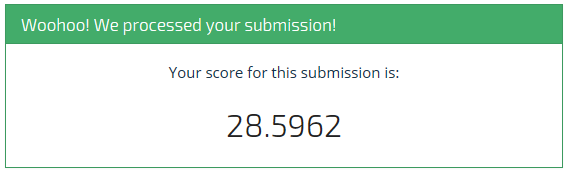

#### Without kernel regularizer, Batch Size 16, window 4:
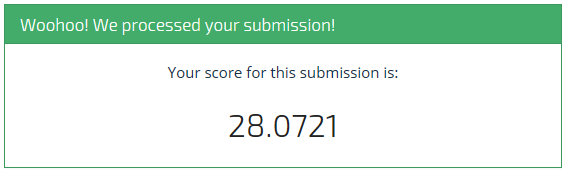

#### Without kernel regularizer, Batch Size 16, window 8:
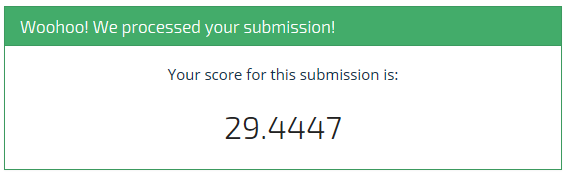

#### With kernel regularizer L2 (0.00001), Batch Size 32, window 2:
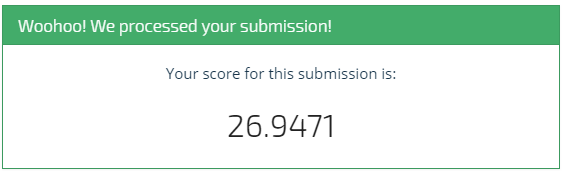

#### With kernel regularizer L2 (0.00001), Batch Size 32, window 4:
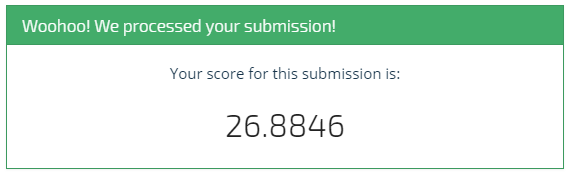